# Model building

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.metrics import plot_roc_curve, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import LSTM, Bidirectional, Conv1D
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPool1D, BatchNormalization
from tensorflow.keras import backend as K
#from tensorflow.keras.layers.embeddings import Embedding

import datetime

import warnings
warnings.filterwarnings("ignore")

In [3]:
df_orig = pd.read_csv("df_processed.csv")
df_orig.replace(np.nan, "no_text", inplace=True)

In [4]:
print ( df_orig.shape, df_orig.columns)
df_orig.head(2)

(541438, 21) Index(['Unnamed: 0', 'id', 'subreddit', 'title', 'author', 'url', 'created',
       'ext_link', 'id.1', 'body', 'score', 'upvote_ratio', 'body_processed',
       'title_processed', 'author_processed', 'subreddit_processed',
       'body_and_title', 'body_and_author', 'title_and_author',
       'body_title_and_author', 'body_title_author_subreddit'],
      dtype='object')


,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,upvote_ratio,body_processed,title_processed,author_processed,subreddit_processed,body_and_title,body_and_author,title_and_author,body_title_and_author,body_title_author_subreddit
0,0,koaw8g,finance,Tech's top seven companies added $3.4 trillion...,Obrocheetah,https://www.reddit.com/r/finance/comments/koaw...,1609505868,no_text,koaw8g,[deleted],...,1.0,deleted,top seven companies added trillion value,obrocheetah,finance,deleted top seven companies added trillion value,deleted obrocheetah,top seven companies added trillion value obroc...,deleted top seven companies added trillion val...,deleted top seven companies added trillion val...
1,1,kobbka,finance,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,https://www.reddit.com/r/finance/comments/kobb...,1609507913,https://www.fintechinshorts.com/mogo-establish...,kobbka,no_text,...,1.0,no_text,mogo establishes atm equity program mogo finan...,fintechinshorts,finance,no_text mogo establishes atm equity program mo...,no_text fintechinshorts,mogo establishes atm equity program mogo finan...,no_text mogo establishes atm equity program mo...,no_text mogo establishes atm equity program mo...


In [5]:
# delete the rows with empty body
df = df_orig[(df_orig.body_processed != 'deleted') & (df_orig.body_processed != 'removed')]
df.head(2)

,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,upvote_ratio,body_processed,title_processed,author_processed,subreddit_processed,body_and_title,body_and_author,title_and_author,body_title_and_author,body_title_author_subreddit
1,1,kobbka,finance,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,https://www.reddit.com/r/finance/comments/kobb...,1609507913,https://www.fintechinshorts.com/mogo-establish...,kobbka,no_text,...,1.0,no_text,mogo establishes atm equity program mogo finan...,fintechinshorts,finance,no_text mogo establishes atm equity program mo...,no_text fintechinshorts,mogo establishes atm equity program mogo finan...,no_text mogo establishes atm equity program mo...,no_text mogo establishes atm equity program mo...
3,3,koe39g,finance,Standard Capital: Partners with SolidBlock Sta...,fintechinshorts,https://www.reddit.com/r/finance/comments/koe3...,1609518689,https://www.fintechinshorts.com/standard-capit...,koe39g,no_text,...,1.0,no_text,standard capital partners solidblock standard ...,fintechinshorts,finance,no_text standard capital partners solidblock s...,no_text fintechinshorts,standard capital partners solidblock standard ...,no_text standard capital partners solidblock s...,no_text standard capital partners solidblock s...


## Popular as 95 percentile

In [6]:
df_superstocks = df[df.subreddit == 'Superstonks']
df_finance     = df[df.subreddit == 'finance']
df_options     = df[df.subreddit == 'options']
df_pennystocks = df[df.subreddit == 'pennystocks']
df_gme         = df[df.subreddit == 'GME']

In [7]:
df_superstocks['popular'] = 0
df_finance['popular'] = 0
df_options['popular'] = 0
df_pennystocks['popular'] = 0
df_gme['popular'] = 0

In [8]:
df_superstocks.loc[df_superstocks['score'] > np.percentile(df_superstocks.score.values, 95), 'popular'] = 1
df_finance.loc[df_finance['score'] > np.percentile(df_finance.score.values, 95), 'popular'] = 1
df_options.loc[df_options['score'] > np.percentile(df_options.score.values, 95), 'popular'] = 1
df_pennystocks.loc[df_pennystocks['score'] > np.percentile(df_pennystocks.score.values, 95), 'popular'] = 1
df_gme.loc[df_gme['score'] > np.percentile(df_gme.score.values, 95), 'popular'] = 1

In [9]:
df = pd.concat([df_superstocks, df_finance, df_options,
                df_pennystocks, df_gme], ignore_index=True)

In [11]:
df.head(2)

,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,body_processed,title_processed,author_processed,subreddit_processed,body_and_title,body_and_author,title_and_author,body_title_and_author,body_title_author_subreddit,popular
0,41437,mkga8b,Superstonks,The sub you are looking for is r/Superstonk,seppukkake,https://www.reddit.com/r/Superstonks/comments/...,1617613228,https://www.reddit.com/r/Superstonks/comments/...,mkga8b,r/Superstonk,...,r superstonk,sub looking r superstonk,seppukkake,superstonks,r superstonk sub looking r superstonk,r superstonk seppukkake,sub looking r superstonk seppukkake,r superstonk sub looking r superstonk seppukkake,r superstonk sub looking r superstonk seppukka...,1
1,41438,mkhpr9,Superstonks,https://www.reddit.com/r/Superstonk/,fairytalee20,https://www.reddit.com/r/Superstonks/comments/...,1617619355,https://www.reddit.com/r/Superstonks/comments/...,mkhpr9,no_text,...,no_text,https www reddit com r superstonk,fairytalee,superstonks,no_text https www reddit com r superstonk,no_text fairytalee,https www reddit com r superstonk fairytalee,no_text https www reddit com r superstonk fair...,no_text https www reddit com r superstonk fair...,0


In [13]:
import string, re, datetime

def emoji_count(s):
    s = ''.join(word.strip(string.punctuation) for word in s.split())
    return len(re.findall('[^\w\s,\(\)\'\/-]',s))

def hourOfDay(utc):
    return datetime.datetime.utcfromtimestamp(utc).hour

def dayOfWeek(utc):
    return datetime.datetime.utcfromtimestamp(utc).weekday()

def textLength(text):
    return len(text.split())

def postType(link):
    if not link:
        return 'others'
    if 'png' in link or 'jpg' in link:
        return 'figures'
    elif '/r/' in link:
        return 'others'
    else:
        return 'outside_link'

def countUpper(text):
    Up = 0
    Low = 0
    for ch in text:
        if ch.isupper():
            Up += 1
        elif ch.islower():
            Low += 1
    
    if Up + Low:
        return Up/(Up+Low)
    else:
        return 0
    
def exclamationAndQuestion(text):
    return text.count('!') + text.count('?')

def getMonth(utc):
    return datetime.datetime.utcfromtimestamp(utc).month
    
def primeTime(hour):
    primeTime = 1 if hour >= 7 and hour <= 11 else 0
    return primeTime

def weekend(day):
    return 1 if day >= 5 else 0

In [14]:
df['title_emoji'] = df['title'].apply(emoji_count)
df['body_emoji'] = df['body'].apply(emoji_count)
df['title_length'] = df['title'].apply(textLength)
df['body_length'] = df['body'].apply(textLength)
df['title_EQ'] = df['title'].apply(exclamationAndQuestion)
df['body_EQ'] = df['body'].apply(exclamationAndQuestion)
#df['title_UL'] = df['title'].apply(countUpper)
#df['body_UL'] = df['body'].apply(countUpper)    
df['hour'] = df['created'].apply(hourOfDay)
df['day'] = df['created'].apply(dayOfWeek)
#df['post_type'] = df['ext_link'].apply(postType)
df['prime_time'] = df['hour'].apply(primeTime)
df['weekend'] = df['day'].apply(weekend)
df['month'] = df['created'].apply(getMonth)

In [15]:
from num2words import num2words

def get_num2words(num):
    w = num2words(num)
    w = re.sub(' ', '_', w)
    w = re.sub('-', '_', w)
    return w

def convert_nums(nums):
    return " ".join([get_num2words(num) for num in nums])

convert_nums([0, 12, 44, 123])

'zero twelve forty_four one_hundred_and_twenty_three'

In [16]:
cols = ['title_emoji', 'body_emoji', 'title_length',
        'body_length','title_EQ','body_EQ', 'hour',
        'day', 'prime_time', 'weekend', 'month']

df['feats_joined_w'] = df[cols].apply(convert_nums, axis=1)
df.head(2)

,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,title_length,body_length,title_EQ,body_EQ,hour,day,prime_time,weekend,month,feats_joined_w
0,41437,mkga8b,Superstonks,The sub you are looking for is r/Superstonk,seppukkake,https://www.reddit.com/r/Superstonks/comments/...,1617613228,https://www.reddit.com/r/Superstonks/comments/...,mkga8b,r/Superstonk,...,8,1,0,0,9,0,1,0,4,zero zero eight one zero zero nine zero one ze...
1,41438,mkhpr9,Superstonks,https://www.reddit.com/r/Superstonk/,fairytalee20,https://www.reddit.com/r/Superstonks/comments/...,1617619355,https://www.reddit.com/r/Superstonks/comments/...,mkhpr9,no_text,...,1,1,0,0,10,0,1,0,4,three zero one one zero zero ten zero one zero...


In [17]:
df['join1'] = df['subreddit'].str.lower() + ' ' + df['body_title_and_author']
df['join2'] = df['join1'] + ' '+ df['feats_joined_w']
df.head(2)

,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,title_EQ,body_EQ,hour,day,prime_time,weekend,month,feats_joined_w,join1,join2
0,41437,mkga8b,Superstonks,The sub you are looking for is r/Superstonk,seppukkake,https://www.reddit.com/r/Superstonks/comments/...,1617613228,https://www.reddit.com/r/Superstonks/comments/...,mkga8b,r/Superstonk,...,0,0,9,0,1,0,4,zero zero eight one zero zero nine zero one ze...,superstonks r superstonk sub looking r superst...,superstonks r superstonk sub looking r superst...
1,41438,mkhpr9,Superstonks,https://www.reddit.com/r/Superstonk/,fairytalee20,https://www.reddit.com/r/Superstonks/comments/...,1617619355,https://www.reddit.com/r/Superstonks/comments/...,mkhpr9,no_text,...,0,0,10,0,1,0,4,three zero one one zero zero ten zero one zero...,superstonks no_text https www reddit com r sup...,superstonks no_text https www reddit com r sup...


## Split data by time

In [18]:
df.head(2)

,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,title_EQ,body_EQ,hour,day,prime_time,weekend,month,feats_joined_w,join1,join2
0,41437,mkga8b,Superstonks,The sub you are looking for is r/Superstonk,seppukkake,https://www.reddit.com/r/Superstonks/comments/...,1617613228,https://www.reddit.com/r/Superstonks/comments/...,mkga8b,r/Superstonk,...,0,0,9,0,1,0,4,zero zero eight one zero zero nine zero one ze...,superstonks r superstonk sub looking r superst...,superstonks r superstonk sub looking r superst...
1,41438,mkhpr9,Superstonks,https://www.reddit.com/r/Superstonk/,fairytalee20,https://www.reddit.com/r/Superstonks/comments/...,1617619355,https://www.reddit.com/r/Superstonks/comments/...,mkhpr9,no_text,...,0,0,10,0,1,0,4,three zero one one zero zero ten zero one zero...,superstonks no_text https www reddit com r sup...,superstonks no_text https www reddit com r sup...


In [19]:
df['posting_time'] = df['created'].apply(datetime.datetime.fromtimestamp)
df['posting_month'] = df['posting_time'].apply(lambda dd: dd.month)
df.head(2)

,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,hour,day,prime_time,weekend,month,feats_joined_w,join1,join2,posting_time,posting_month
0,41437,mkga8b,Superstonks,The sub you are looking for is r/Superstonk,seppukkake,https://www.reddit.com/r/Superstonks/comments/...,1617613228,https://www.reddit.com/r/Superstonks/comments/...,mkga8b,r/Superstonk,...,9,0,1,0,4,zero zero eight one zero zero nine zero one ze...,superstonks r superstonk sub looking r superst...,superstonks r superstonk sub looking r superst...,2021-04-05 05:00:28,4
1,41438,mkhpr9,Superstonks,https://www.reddit.com/r/Superstonk/,fairytalee20,https://www.reddit.com/r/Superstonks/comments/...,1617619355,https://www.reddit.com/r/Superstonks/comments/...,mkhpr9,no_text,...,10,0,1,0,4,three zero one one zero zero ten zero one zero...,superstonks no_text https www reddit com r sup...,superstonks no_text https www reddit com r sup...,2021-04-05 06:42:35,4


In [21]:
df = df[["posting_month", "join1", "join2", "popular"]]
df.head(2)

,posting_month,join1,join2,popular
0,4,superstonks r superstonk sub looking r superst...,superstonks r superstonk sub looking r superst...,1
1,4,superstonks no_text https www reddit com r sup...,superstonks no_text https www reddit com r sup...,0


In [22]:
df_train = df[df['posting_month']<4]
df_test  = df[df['posting_month']==4]

In [23]:
print (f"Training Shape: {df_train.shape[0]},  Test shape: {df_test.shape[0]}")

Training Shape: 99226,  Test shape: 27072


In [24]:
df_train.head(2)

,posting_month,join1,join2,popular
120,1,finance no_text mogo establishes atm equity pr...,finance no_text mogo establishes atm equity pr...,0
121,1,finance no_text standard capital partners soli...,finance no_text standard capital partners soli...,0


In [25]:
def check_distribution(df, ycol='popular'):
    labels = df.groupby(ycol).count().iloc[:2,0].values
    print (labels, np.round(100*labels/sum(labels), 2))

In [26]:
check_distribution(df)

[126282   6640] [95.  5.]


In [27]:
check_distribution(df_train)

[94780  4446] [95.52  4.48]


In [28]:
check_distribution(df_test)

[25230  1842] [93.2  6.8]


## Convert text to vector

In [29]:
xcol = 'join2'
ycol = 'popular'

In [30]:
MAX_WORDS   = 1000
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df_train[xcol])
X_train = tokenizer.texts_to_matrix(df_train[xcol])
X_test  = tokenizer.texts_to_matrix(df_test[xcol])

In [31]:
y_train = df_train[ycol]
y_test  = df_test[ycol]

In [32]:
y_train.shape[0]

99226

In [34]:
nr = lambda x: np.round(100*x, 2)

In [35]:
def get_train_val(X_train, y_train, fraction=0.9):
    indx = int(fraction*y_train.shape[0])
    tt = y_train[:indx ]
    tv = y_train[indx: ]
    print ( "Original Fraction:", nr(y_train.sum()/(len(y_train)+0.0)))
    print ( f"Fraction Train: {nr(tt.sum()/(len(tt)+0.0))}%, Validation, {nr(tv.sum()/(len(tv)+0.0))}%")
    
    return (X_train[:indx], y_train[:indx], X_train[indx:], y_train[indx:] )

X_train_, y_train_, X_val, y_val = get_train_val(X_train, y_train)

Original Fraction: 4.48
Fraction Train: 4.04%, Validation, 8.42%


## Dense Layer

In [36]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [68]:
def make_model(X):
    model = Sequential()
    model.add(Dense(16, input_shape=(X.shape[1],), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics = [precision_m, recall_m])
    return model

In [121]:
# Time series data without validation

In [38]:
model1 = make_model(X_train)
display ( model1.summary() )
history1 = model1.fit(X_train, y_train,
                      batch_size=128,
                      epochs=20,
                      verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                32032     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 32,065
Trainable params: 32,065
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/20
776/776 [==============================] - 2s 2ms/step - loss: 0.1876 - precision_m: 4.2955e-04 - recall_m: 2.5773e-04: 0s - loss: 0.1912 - precision_m: 5.5463e-04 - recall_m
Epoch 2/20
776/776 [==============================] - 1s 2ms/step - loss: 0.1659 - precision_m: 0.0200 - recall_m: 0.0036
Epoch 3/20
776/776 [==============================] - 1s 2ms/step - loss: 0.1610 - precision_m: 0.1267 - recall_m: 0.0254: 0s - loss: 0.1581 - precision_m: 0.120
Epoch 4/20
776/776 [==============================] - 1s 1ms/step - loss: 0.1566 - precision_m: 0.2433 - recall_m: 0.0542
Epoch 5/20
776/776 [==============================] - 1s 1ms/step - loss: 0.1511 - precision_m: 0.3120 - recall_m: 0.0704
Epoch 6/20
776/776 [==============================] - 1s 1ms/step - loss: 0.1461 - precision_m: 0.4355 - recall_m: 0.1032
Epoch 7/20
776/776 [==============================] - 1s 2ms/step - loss: 0.1422 - precision_m: 0.4844 - recall_m: 0.1220: 0s - loss: 0.1444 - 
Epoch 8/20
776/776 [

In [40]:
proba = model1.predict_proba(X_train)

In [47]:
th = .5
pred = (proba.flatten()>th).astype(int)
np.sum(pred==y_train)/len(y_train)

0.970451293007881

In [58]:
def plot_precision_recall(model, X, y, ax=None, lab="Data"):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(6,5))
    pr, re, th = precision_recall_curve(y, model1.predict_proba(X)[:,1] )
    ax.plot(re, pr, label=lab)    
    
def save_pr_data(model, X, y, save_name):
    
    proba = model.predict_proba(X)
    pr = []; re = []
    cutoffs = np.linspace(0.05, 0.99, 100)
    for c in cutoffs:
        preds_c = (proba.flatten()>=c).astype('int')
        pr_ = precision_score(y, preds_c)
        re_ = recall_score(y, preds_c)
        pr.append( pr_ )
        re.append( re_ )
        
    pr_re = np.stack([pr, re], axis=1)
    np.savetxt(save_name, pr_re)
    print ("saved pr-re data.")
    
def precision_recall_curve(model, X, y, ax=None, lab="Data"):
    proba = model.predict_proba(X)
    pr = []; re = []
    cutoffs = np.linspace(0.05, 0.99, 100)
    for c in cutoffs:
        preds_c = (proba.flatten()>=c).astype('int')
        pr_ = precision_score(y, preds_c)
        re_ = recall_score(y, preds_c)
        pr.append( pr_ )
        re.append( re_ )
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(6,4))
    ax.plot(re, pr, '-o', label=lab)
    ax.set_xlabel("Recall", fontsize=16)
    ax.set_ylabel("Precision", fontsize=16)
    ax.legend(fontsize=16)

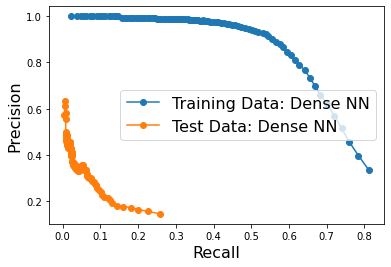

In [55]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
precision_recall_curve(model1, X_train, y_train, ax=ax, lab="Training Data: Dense NN")
precision_recall_curve(model1, X_test, y_test, ax=ax, lab="Test Data: Dense NN")

saved pr-re data.


In [62]:
save_pr_data(model1, X_train, y_train, "pr_re_train_DNN.dat")
save_pr_data(model1, X_test, y_test, "pr_re_test_DNN.dat")

saved pr-re data.


In [63]:
pr_LR_train = np.loadtxt('pr_re_train.dat')
pr_LR_test = np.loadtxt('pr_re_test.dat')
pr_DN_train = np.loadtxt('pr_re_train_DNN.dat')
pr_DN_test = np.loadtxt('pr_re_test_DNN.dat')

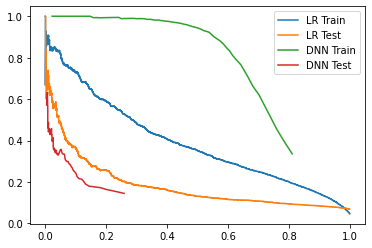

In [67]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.plot(pr_LR_train[:,1], pr_LR_train[:,0], label="LR Train")
ax.plot(pr_LR_test[:,1], pr_LR_test[:,0], label="LR Test")
ax.plot(pr_DN_train[:,1], pr_DN_train[:,0], label="DNN Train")
ax.plot(pr_DN_test[:,1], pr_DN_test[:,0], label="DNN Test")
ax.legend()

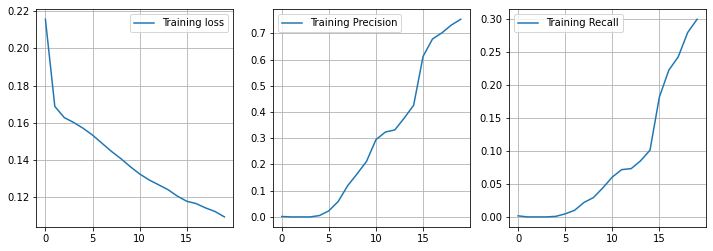

In [124]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history1.history['loss'], label='Training loss')
plt.legend(); plt.grid()
plt.subplot(132)
plt.plot(history1.history['precision_m'], label='Training Precision')
plt.legend(); plt.grid()
plt.subplot(133)
plt.plot(history1.history['recall_m'], label='Training Recall')
plt.legend(); plt.grid()

In [127]:
nr = lambda x: np.round(100*x, 2)

In [129]:
loss, pr, re = model1.evaluate(X_test, y_test, verbose=0)
print (f"Loss: {nr(loss)}%, Precision: {nr(pr)}%, Recall:{nr(re)}%")

Loss: 28.14%, Precision: 5.08%, Recall:1.86%


In [69]:
model2 = make_model(X_train_)
display ( model2.summary() )
history2 = model2.fit(X_train_, y_train_,
                      validation_data=(X_val, y_val),
                      batch_size=128,
                      epochs=20,
                      verbose=0)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                16016     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 16,033
Trainable params: 16,033
Non-trainable params: 0
_________________________________________________________________


None

In [70]:
save_pr_data(model2, X_train, y_train, "pr_re_train_DNN_2.dat")
save_pr_data(model2, X_test, y_test, "pr_re_test_DNN_2.dat")

saved pr-re data.
saved pr-re data.


In [71]:
pr_DN_train2 = np.loadtxt('pr_re_train_DNN_2.dat')
pr_DN_test2  = np.loadtxt('pr_re_test_DNN_2.dat')

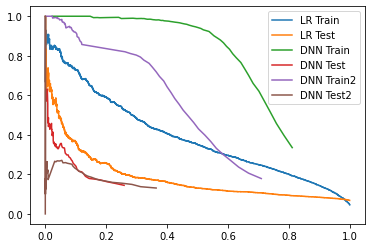

In [72]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.plot(pr_LR_train[:,1], pr_LR_train[:,0], label="LR Train")
ax.plot(pr_LR_test[:,1], pr_LR_test[:,0], label="LR Test")
ax.plot(pr_DN_train[:,1], pr_DN_train[:,0], label="DNN Train")
ax.plot(pr_DN_test[:,1], pr_DN_test[:,0], label="DNN Test")

ax.plot(pr_DN_train2[:,1], pr_DN_train2[:,0], label="DNN Train2")
ax.plot(pr_DN_test2[:,1], pr_DN_test2[:,0], label="DNN Test2")

ax.legend()

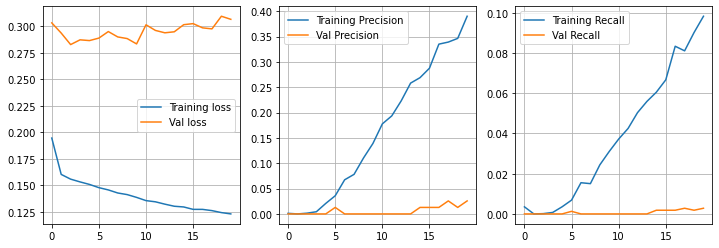

In [73]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Val loss')

plt.legend(); plt.grid()
plt.subplot(132)
plt.plot(history2.history['precision_m'], label='Training Precision')
plt.plot(history2.history['val_precision_m'], label='Val Precision')
plt.legend(); plt.grid()
plt.subplot(133)
plt.plot(history2.history['recall_m'], label='Training Recall')
plt.plot(history2.history['val_recall_m'], label='Val Recall')
plt.legend(); plt.grid()

In [ ]:
th = 0.5
pred = (model1.predict(X_test) > th).ravel().astype('int')
pred[:10]

In [ ]:
ac = accuracy_score(y_test, pred)
pr = precision_score(y_test, pred)
re = recall_score(y_test, pred)
print (ac, pr, re)

In [79]:
import tensorflow as tf
#tf.keras.layers.Embedding(1000, 64, input_length=10))

## LSTM Layers

In [90]:
def make_model2(X, embedding_length = 16):
    model = Sequential()
    model.add(tf.keras.layers.Embedding(MAX_WORDS, embedding_length, input_length=X.shape[1]))
    model.add(LSTM(16, activation='relu'))
    model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    #model.add(Flatten())
    #model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics = [precision_m, recall_m])
    return model

In [91]:
model3 = make_model2(X_train_)
display( model3.summary() )

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 16)          16000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 18,129
Trainable params: 18,129
Non-trainable params: 0
_________________________________________________________________


None

In [92]:
history3 = model3.fit(X_train_, y_train_,
                      validation_data=(X_val, y_val),
                      batch_size=256,
                      epochs=2,
                      verbose=1)


Epoch 1/2
349/349 [==============================] - 172s 489ms/step - loss: 8099.4019 - precision_m: 4.5693e-04 - recall_m: 0.0037 - val_loss: 0.4305 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/2
349/349 [==============================] - 170s 488ms/step - loss: 0.3494 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.3609 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00


In [94]:
save_pr_data(model3, X_train, y_train, "pr_re_train_LSTM.dat")
save_pr_data(model3, X_test, y_test, "pr_re_test_LSTM.dat")

saved pr-re data.
saved pr-re data.


In [95]:
pr_LSTM_train = np.loadtxt('pr_re_train_LSTM.dat')
pr_LSTM_test  = np.loadtxt('pr_re_test_LSTM.dat')

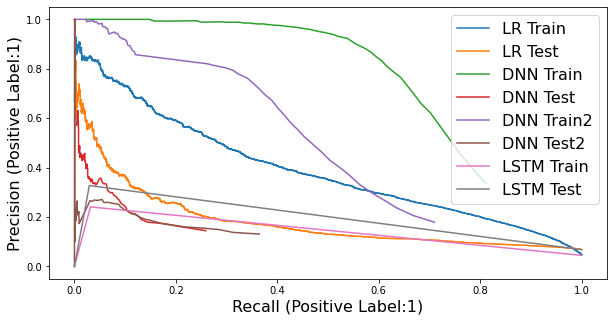

In [98]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(pr_LR_train[:,1], pr_LR_train[:,0], label="LR Train")
ax.plot(pr_LR_test[:,1], pr_LR_test[:,0], label="LR Test")
ax.plot(pr_DN_train[:,1], pr_DN_train[:,0], label="DNN Train")
ax.plot(pr_DN_test[:,1], pr_DN_test[:,0], label="DNN Test")

ax.plot(pr_DN_train2[:,1], pr_DN_train2[:,0], label="DNN Train2")
ax.plot(pr_DN_test2[:,1], pr_DN_test2[:,0], label="DNN Test2")

ax.plot(pr_LSTM_train[:,1], pr_LSTM_train[:,0], label="LSTM Train")
ax.plot(pr_LSTM_test[:,1], pr_LSTM_test[:,0], label="LSTM Test")

ax.set_xlabel("Recall (Positive Label:1)", fontsize=16)
ax.set_ylabel("Precision (Positive Label:1)", fontsize=16)
ax.legend(fontsize=16)

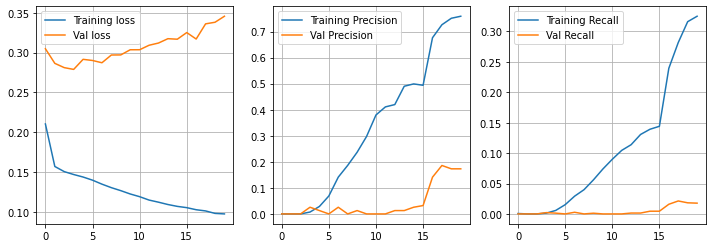

In [150]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Val loss')
plt.legend(); plt.grid()

plt.subplot(132)
plt.plot(history2.history['precision_m'], label='Training Precision')
plt.plot(history2.history['val_precision_m'], label='Val Precision')
plt.legend(); plt.grid()

plt.subplot(133)
plt.plot(history2.history['recall_m'], label='Training Recall')
plt.plot(history2.history['val_recall_m'], label='Val Recall')
plt.legend(); plt.grid()

In [167]:
proba = model2.predict_proba(X_test)

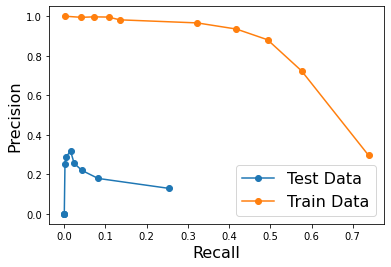

In [197]:
def precision_recall_curve(model, X, y, ax=None, lab="Data"):
    proba = model.predict_proba(X)
    pr = []; re = []
    cutoffs = np.linspace(0.05, 0.99, 10)
    for c in cutoffs:
        preds_c = (proba.flatten()>=c).astype('int')
        pr_ = precision_score(y, preds_c)
        re_ = recall_score(y, preds_c)
        pr.append( pr_ )
        re.append( re_ )
        #print (c, pr_, re_ )
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(6,4))
    ax.plot(re, pr, '-o', label=lab)
    ax.set_xlabel("Recall", fontsize=16)
    ax.set_ylabel("Precision", fontsize=16)
    ax.legend(fontsize=16)
    
    
fig, ax = plt.subplots(1,1, figsize=(6,4))
precision_recall_curve(model2, X_test, y_test, ax=ax, lab = "Test Data")
precision_recall_curve(model2, X_train, y_train, ax=ax, lab = "Train Data")

In [203]:
#1.19.3
!pip3 install numpy==1.19.3

     |████████████████████████████████| 15.9 MB 1.6 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
qiskit-aqua 0.9.1 requires pandas<=1.2.3, but you have pandas 1.2.4 which is incompatible.
qiskit-aqua 0.9.1 requires scikit-learn<=0.24.1,>=0.20.0, but you have scikit-learn 0.24.2 which is incompatible.


In [204]:
def make_model_GRU(X, embedding_length = 16):
    model = Sequential()
    model.add(tf.keras.layers.Embedding(MAX_WORDS, embedding_length, input_length=X.shape[1]))
    model.add(GRU(128, dropout=0.2, return_sequences=True)) 
    model.add(GRU(128, dropout=0.2))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics = [precision_m, recall_m])
    return model

In [205]:
model3 = make_model_GRU(X_train_)
model3.summary()

NotImplementedError: Cannot convert a symbolic Tensor (gru_1/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [202]:
print (np.__version__)

1.20.1


In [200]:

history3 = model3.fit(X_train_, y_train_,
                      validation_data=(X_val, y_val),
                      batch_size=128,
                      epochs=20,
                      verbose=1)


NameError: name 'model3' is not defined

In [174]:
import nltk

In [175]:
fil = "../04_webapp/english_STOPWORDS"

In [189]:
sw = open(fil, 'r')
set([w.strip("\n") for w in sw.readlines()])
#    .strip('\n'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

"i\nme\nmy\nmyself\nwe\nour\nours\nourselves\nyou\nyou're\nyou've\nyou'll\nyou'd\nyour\nyours\nyourself\nyourselves\nhe\nhim\nhis\nhimself\nshe\nshe's\nher\nhers\nherself\nit\nit's\nits\nitself\nthey\nthem\ntheir\ntheirs\nthemselves\nwhat\nwhich\nwho\nwhom\nthis\nthat\nthat'll\nthese\nthose\nam\nis\nare\nwas\nwere\nbe\nbeen\nbeing\nhave\nhas\nhad\nhaving\ndo\ndoes\ndid\ndoing\na\nan\nthe\nand\nbut\nif\nor\nbecause\nas\nuntil\nwhile\nof\nat\nby\nfor\nwith\nabout\nagainst\nbetween\ninto\nthrough\nduring\nbefore\nafter\nabove\nbelow\nto\nfrom\nup\ndown\nin\nout\non\noff\nover\nunder\nagain\nfurther\nthen\nonce\nhere\nthere\nwhen\nwhere\nwhy\nhow\nall\nany\nboth\neach\nfew\nmore\nmost\nother\nsome\nsuch\nno\nnor\nnot\nonly\nown\nsame\nso\nthan\ntoo\nvery\ns\nt\ncan\nwill\njust\ndon\ndon't\nshould\nshould've\nnow\nd\nll\nm\no\nre\nve\ny\nain\naren\naren't\ncouldn\ncouldn't\ndidn\ndidn't\ndoesn\ndoesn't\nhadn\nhadn't\nhasn\nhasn't\nhaven\nhaven't\nisn\nisn't\nma\nmightn\nmightn't\nmustn\nmus

In [190]:
#import sklearn
!pip3 install scikit-learn --upgrade

In [191]:
import sklearn

In [192]:
sklearn.__version__

'0.24.1'

In [193]:
import pandas 
pandas.__version__

'1.2.3'

In [195]:
import pickle

In [100]:
int(True)

1

In [101]:
import xgboost

In [102]:
xgboost.__version__

'1.4.2'

In [103]:
import sklearn
sklearn.__version__

'0.24.2'